In [1]:
import numpy as np
import pandas as pd
import time, os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from tensorboard.plugins.hparams import api as hp

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split as split

import random
from math import floor
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from scipy.integrate import odeint
import scipy
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
df=pd.read_csv('data/jla.csv')
N = len(df.values)
randomize = np.random.permutation(N)
data = df.values[randomize]
N = len(df.values)
z = data[:,0] 
y = data[:,1:3] ### coge el resto de variables a predecir 
y[:,1] = y[:,1]**2+data[:,2]
np.shape(y)
df

,zcmb,mb,dmb,errors
0,0.503084,23.001698,0.088031,0.120219
1,0.580724,23.573937,0.090132,0.121435
2,0.494795,22.960139,0.088110,0.089552
3,0.345928,22.398137,0.087263,0.119729
4,0.677662,24.078115,0.098356,0.100088
...,...,...,...,...
735,0.027064,16.504006,0.141685,0.185894
736,0.025468,15.797848,0.143429,0.193666
737,0.023810,15.895501,0.144315,0.184957
738,0.023867,16.068268,0.144350,0.175960


In [3]:
dmag =df["dmb"]

df2=df['errors']+df['dmb']**2

In [4]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
z = scalerz.transform(z.reshape(-1,1))

In [5]:
### Modificar para incluir phanteon como test
split = 0.75
ntrain = int(split * len(z))
indx = [ntrain]
X_train, X_test = np.split(z, indx)
Y_train, Y_test = np.split(y, indx)
np.shape(X_train), np.shape(X_test), Y_train.shape, Y_test.shape

((555, 1), (185, 1), (555, 2), (185, 2))

In [6]:
# loss -> val_loss
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=100,
                                   restore_best_weights=True, verbose=True)
                                   ]

n_cols = 1

In [7]:
epochs=500

In [8]:
def train_test_model(hparams):    
    
    # Train LSTM model and predict on validation set
    model = tf.keras.Sequential()
    model.add(Input(shape=(int(X_train.shape[1]),)))
    model.add(Dense(hparams['HP_NUM_UNITS'], input_shape=(int(X_train.shape[1]),)))
    
    for i in range(hparams['HP_LAYERS']):        
        model.add(Dense(hparams['HP_NUM_UNITS'], activation='relu'))
    model.add(Dense(2, activation='linear'))
     
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams['HP_LEARNING'], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(
            optimizer=optimizer,
            loss='mse', 
            metrics=['mean_squared_error'])
    
    # Run with 1 epoch to speed things up for demo purposes

    train = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_test, Y_test),
              callbacks=callbacks, batch_size=hparams['HP_BATCHSIZE'], shuffle=True, verbose=True)

    _, loss = model.evaluate(X_test, Y_test)
    
    return model, loss, train.history

# Grid results

- layers:4
- nodes: 200
- lr: 0.00010
- bs = 8

loss = 0.030958

In [9]:
hparams = {'HP_LAYERS': 4, 'HP_NUM_UNITS': 200, 'HP_BATCHSIZE': 8, 'HP_LEARNING':0.0001}

In [10]:
model, loss_test, history = train_test_model(hparams)

Epoch 1/500
70/70 [==============================] - 2s 10ms/step - loss: 207.0301 - mean_squared_error: 207.0301 - val_loss: 180.5018 - val_mean_squared_error: 180.5018
Epoch 2/500
70/70 [==============================] - 0s 5ms/step - loss: 93.8055 - mean_squared_error: 93.8055 - val_loss: 48.5928 - val_mean_squared_error: 48.5928
Epoch 3/500
70/70 [==============================] - 0s 5ms/step - loss: 42.8743 - mean_squared_error: 42.8743 - val_loss: 37.7841 - val_mean_squared_error: 37.7841
Epoch 4/500
70/70 [==============================] - 0s 6ms/step - loss: 30.8530 - mean_squared_error: 30.8530 - val_loss: 22.0845 - val_mean_squared_error: 22.0845
Epoch 5/500
70/70 [==============================] - 0s 6ms/step - loss: 15.1928 - mean_squared_error: 15.1928 - val_loss: 6.5761 - val_mean_squared_error: 6.5761
Epoch 6/500
70/70 [==============================] - 0s 5ms/step - loss: 4.4809 - mean_squared_error: 4.4809 - val_loss: 1.4388 - val_mean_squared_error: 1.4388
Epoch 7/500

70/70 [==============================] - 0s 5ms/step - loss: 0.0723 - mean_squared_error: 0.0723 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 51/500
70/70 [==============================] - 0s 6ms/step - loss: 0.0648 - mean_squared_error: 0.0648 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 52/500
70/70 [==============================] - 0s 6ms/step - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 53/500
70/70 [==============================] - 0s 5ms/step - loss: 0.0620 - mean_squared_error: 0.0620 - val_loss: 0.0411 - val_mean_squared_error: 0.0411
Epoch 54/500
70/70 [==============================] - 0s 5ms/step - loss: 0.0592 - mean_squared_error: 0.0592 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 55/500
70/70 [==============================] - 0s 6ms/step - loss: 0.0725 - mean_squared_error: 0.0725 - val_loss: 0.0403 - val_mean_squared_error: 0.0403
Epoch 56/500
70/70 [=====================

70/70 [==============================] - 0s 4ms/step - loss: 0.0720 - mean_squared_error: 0.0720 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 101/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 102/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0824 - mean_squared_error: 0.0824 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 103/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0618 - mean_squared_error: 0.0618 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 104/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - val_loss: 0.0516 - val_mean_squared_error: 0.0516
Epoch 105/500
70/70 [==============================] - 0s 5ms/step - loss: 0.0594 - mean_squared_error: 0.0594 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 106/500
70/70 [===============

70/70 [==============================] - 0s 4ms/step - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 151/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0533 - mean_squared_error: 0.0533 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 152/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0609 - mean_squared_error: 0.0609 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 153/500
70/70 [==============================] - 0s 5ms/step - loss: 0.0552 - mean_squared_error: 0.0552 - val_loss: 0.0430 - val_mean_squared_error: 0.0430
Epoch 154/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0590 - mean_squared_error: 0.0590 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 155/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0488 - mean_squared_error: 0.0488 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 156/500
70/70 [===============

70/70 [==============================] - 0s 4ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 0.0679 - val_mean_squared_error: 0.0679
Epoch 201/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0582 - mean_squared_error: 0.0582 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 202/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 0.0418 - val_mean_squared_error: 0.0418
Epoch 203/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 204/500
70/70 [==============================] - 0s 6ms/step - loss: 0.0558 - mean_squared_error: 0.0558 - val_loss: 0.0384 - val_mean_squared_error: 0.0384
Epoch 205/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0652 - mean_squared_error: 0.0652 - val_loss: 0.0415 - val_mean_squared_error: 0.0415
Epoch 206/500
70/70 [===============

70/70 [==============================] - 0s 5ms/step - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0527 - val_mean_squared_error: 0.0527
Epoch 251/500
70/70 [==============================] - 0s 5ms/step - loss: 0.0584 - mean_squared_error: 0.0584 - val_loss: 0.0439 - val_mean_squared_error: 0.0439
Epoch 252/500
70/70 [==============================] - 0s 5ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0658 - val_mean_squared_error: 0.0658
Epoch 253/500
70/70 [==============================] - 0s 5ms/step - loss: 0.0544 - mean_squared_error: 0.0544 - val_loss: 0.0598 - val_mean_squared_error: 0.0598
Epoch 254/500
70/70 [==============================] - 0s 5ms/step - loss: 0.0481 - mean_squared_error: 0.0481 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Restoring model weights from the end of the best epoch.
Epoch 00254: early stopping
6/6 [==============================] - 0s 4ms/step - loss: 0.0287 - mean_squared_error: 0.0287


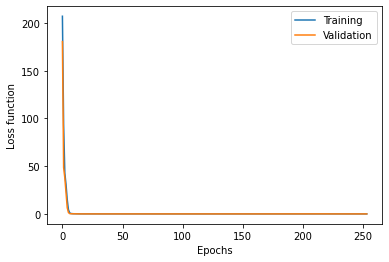

In [11]:
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.ylabel('Loss function')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

In [12]:
loss_test

0.028696095570921898

# Genetic results
3 	100 	0.0001 	8 	
- layer = 3 	
- nodes = 100 	
- lr = 0.00010 	
- bs = 8

loss = 0.027708

In [13]:
hparams_gen = {'HP_LAYERS': 3, 'HP_NUM_UNITS': 100, 'HP_BATCHSIZE': 8, 'HP_LEARNING':0.0001}

In [14]:
model_gen, loss_test_gen, history_gen = train_test_model(hparams_gen)

Epoch 1/500
70/70 [==============================] - 1s 7ms/step - loss: 215.2133 - mean_squared_error: 215.2133 - val_loss: 212.6546 - val_mean_squared_error: 212.6546
Epoch 2/500
70/70 [==============================] - 0s 4ms/step - loss: 193.7220 - mean_squared_error: 193.7220 - val_loss: 175.1963 - val_mean_squared_error: 175.1963
Epoch 3/500
70/70 [==============================] - 0s 4ms/step - loss: 132.0852 - mean_squared_error: 132.0852 - val_loss: 91.5475 - val_mean_squared_error: 91.5475
Epoch 4/500
70/70 [==============================] - 0s 4ms/step - loss: 60.5939 - mean_squared_error: 60.5939 - val_loss: 47.3738 - val_mean_squared_error: 47.3738
Epoch 5/500
70/70 [==============================] - 0s 4ms/step - loss: 42.8241 - mean_squared_error: 42.8241 - val_loss: 41.0829 - val_mean_squared_error: 41.0829
Epoch 6/500
70/70 [==============================] - 0s 4ms/step - loss: 36.9531 - mean_squared_error: 36.9531 - val_loss: 34.4176 - val_mean_squared_error: 34.4176


70/70 [==============================] - 0s 4ms/step - loss: 0.0826 - mean_squared_error: 0.0826 - val_loss: 0.0585 - val_mean_squared_error: 0.0585
Epoch 51/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - val_loss: 0.0513 - val_mean_squared_error: 0.0513
Epoch 52/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.0499 - val_mean_squared_error: 0.0499
Epoch 53/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0764 - mean_squared_error: 0.0764 - val_loss: 0.0481 - val_mean_squared_error: 0.0481
Epoch 54/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0732 - mean_squared_error: 0.0732 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 55/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0706 - mean_squared_error: 0.0706 - val_loss: 0.0484 - val_mean_squared_error: 0.0484
Epoch 56/500
70/70 [=====================

70/70 [==============================] - 0s 4ms/step - loss: 0.0590 - mean_squared_error: 0.0590 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 101/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0598 - mean_squared_error: 0.0598 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 102/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0590 - mean_squared_error: 0.0590 - val_loss: 0.0414 - val_mean_squared_error: 0.0414
Epoch 103/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0338 - val_mean_squared_error: 0.0338
Epoch 104/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0552 - mean_squared_error: 0.0552 - val_loss: 0.0616 - val_mean_squared_error: 0.0616
Epoch 105/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0599 - mean_squared_error: 0.0599 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 106/500
70/70 [===============

70/70 [==============================] - 0s 4ms/step - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 151/500
70/70 [==============================] - 0s 5ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 0.0701 - val_mean_squared_error: 0.0701
Epoch 152/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 153/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0524 - mean_squared_error: 0.0524 - val_loss: 0.0595 - val_mean_squared_error: 0.0595
Epoch 154/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0515 - mean_squared_error: 0.0515 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 155/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0597 - mean_squared_error: 0.0597 - val_loss: 0.0537 - val_mean_squared_error: 0.0537
Epoch 156/500
70/70 [===============

70/70 [==============================] - 0s 4ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - val_loss: 0.0399 - val_mean_squared_error: 0.0399
Epoch 201/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0384 - val_mean_squared_error: 0.0384
Epoch 202/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - val_loss: 0.0548 - val_mean_squared_error: 0.0548
Epoch 203/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0575 - mean_squared_error: 0.0575 - val_loss: 0.0332 - val_mean_squared_error: 0.0332
Epoch 204/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 205/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 206/500
70/70 [===============

70/70 [==============================] - 0s 4ms/step - loss: 0.0493 - mean_squared_error: 0.0493 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 251/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0498 - mean_squared_error: 0.0498 - val_loss: 0.0490 - val_mean_squared_error: 0.0490
Epoch 252/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0494 - mean_squared_error: 0.0494 - val_loss: 0.0321 - val_mean_squared_error: 0.0321
Epoch 253/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0530 - val_mean_squared_error: 0.0530
Epoch 254/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 255/500
70/70 [==============================] - 0s 5ms/step - loss: 0.0464 - mean_squared_error: 0.0464 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 256/500
70/70 [===============

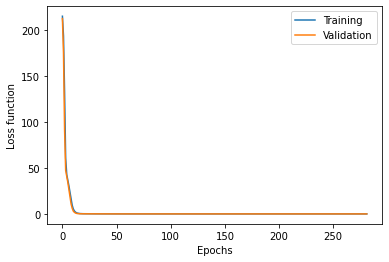

In [15]:
plt.plot(history_gen['loss'], label='Training')
plt.plot(history_gen['val_loss'], label='Validation')
plt.ylabel('Loss function')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

In [16]:
loss_test_gen

0.02839978225529194

In [20]:
# ranz = np.random.uniform(0, 2, size=10000)
ranz = np.linspace(np.min(df['zcmb']), np.max(df['zcmb']), 1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random_gen = model_gen.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
pred_random_grid = model.predict(r)


Text(0, 0.5, '$\\mu(z)$')

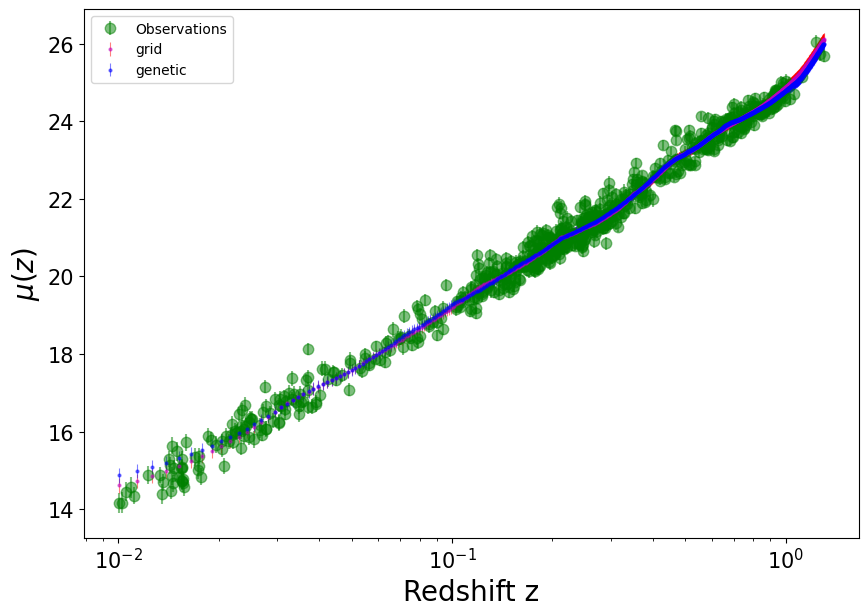

In [21]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb'], df2, fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random_grid[:,0], pred_random_grid[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m', label='grid')
plt.errorbar(rr, pred_random_gen[:,0], pred_random_gen[:,1], markersize=2, fmt='o', 
             ecolor='b', capthick=2, elinewidth=0.8, alpha=0.5, c='b', label='genetic')
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.xscale('log')

plt.ylabel("$\mu(z)$", fontsize=20)
# plt.xlim(1e-6, 1.3)